In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from src.medidas_desempeno_biclase import calcula_medidas_biclase
from src.visualiza_svm import visualiza_svm

### Importar Datasets

In [4]:
df = pd.read_csv('data/iris_df.csv')
df_cnn = pd.read_csv('data/iris_cnn.csv')

In [14]:
df.head()

,petal length (cm),sepal width (cm),target
0,4.7,3.2,versicolor
1,4.5,3.2,versicolor
2,4.9,3.1,versicolor
3,4.0,2.3,versicolor
4,4.6,2.8,versicolor


In [5]:
df.shape, df_cnn.shape

((70, 3), (16, 3))

### Datos estratificados para cada modelo

In [6]:
Xdf_train, Xdf_test, ydf_train, ydf_test = train_test_split(
    df.drop('target', axis=1),
    df['target'],
    test_size=0.2,
    stratify=df['target'],
    random_state=42)

encoder_df = LabelEncoder()
ydf_train = encoder_df.fit_transform(ydf_train)
ydf_test = encoder_df.transform(ydf_test)

Xcnn_train, Xcnn_test, ycnn_train, ycnn_test = train_test_split(
    df_cnn.drop('target', axis=1),
    df_cnn['target'],
    test_size=0.2,
    stratify=df_cnn['target'],
    random_state=42)

encoder_cnn = LabelEncoder()
ycnn_train = encoder_cnn.fit_transform(ycnn_train)
ycnn_test = encoder_cnn.transform(ycnn_test)

### Entrenar SVM    

In [7]:
### Entrenamiento para el dataset original

svm_model_original = svm.SVC()
cv_vals = [5, 10]
resultados_svm_original = []

params = {'kernel' : ['linear'],
    'C': [3, 5, 7, 9],
    'gamma': [0.0002, 0.0003, 0.0004, 0.0005]}

medidas = {
        'balanced_accuracy': 'balanced_accuracy'}

for cval in cv_vals:    
    grid = GridSearchCV(
        estimator = svm_model_original,
        param_grid = params,
        cv = cval,
        scoring = medidas,
        refit = 'balanced_accuracy',
        n_jobs = -1)

    grid.fit(Xdf_train, ydf_train)
    resultados_svm_original.append({
        'cv': cval,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_, 
        'medidas': grid.cv_results_})

svm_model_df = grid.best_estimator_
    
print(f"Modelo SVM con kernel={svm_model_df.kernel} y C={svm_model_df.C}")

Modelo SVM con kernel=linear y C=7


In [8]:
### Entrenamiento para el dataset modificado con CNN

svm_model_cnn = svm.SVC()
cv_vals = [5, 10]
resultados_svm_cnn = []

params = {'kernel' : ['linear'],
    'C': [3, 5, 7, 9],
    'gamma': [0.0002, 0.0003, 0.0004, 0.0005]}

medidas = {
        'balanced_accuracy': 'balanced_accuracy'}

for cval in cv_vals:    
    grid = GridSearchCV(
        estimator = svm_model_cnn,
        param_grid = params,
        cv = cval,
        scoring = medidas,
        refit = 'balanced_accuracy',
        n_jobs = -1)

    grid.fit(Xdf_train, ydf_train)
    resultados_svm_cnn.append({
        'cv': cval,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_, 
        'medidas': grid.cv_results_})

svm_model_cnn = grid.best_estimator_
    
print(f"Modelo SVM con kernel={svm_model_cnn.kernel} y C={svm_model_cnn.C}")

Modelo SVM con kernel=linear y C=7


### Predicciones y evaluar

In [9]:
y_scores_df = svm_model_df.predict(Xdf_test)

medidas_df = calcula_medidas_biclase(ydf_test, y_scores_df)
medidas_df.head()

,Medida,Valor
0,Accuracy,0.857143
1,Error Rate,0.142857
2,Recall (Sensitivity),0.750000
3,Specificity,0.900000
4,Balanced Accuracy,0.825000


In [10]:
y_scores_cnn = svm_model_cnn.predict(Xcnn_test)

medidas_cnn = calcula_medidas_biclase(ycnn_test, y_scores_cnn)
medidas_cnn.head()

,Medida,Valor
0,Accuracy,1.0
1,Error Rate,0.0
2,Recall (Sensitivity),1.0
3,Specificity,1.0
4,Balanced Accuracy,1.0


In [11]:
print(pd.Series(ydf_train).value_counts())

0    40
1    16
Name: count, dtype: int64


### Visualizar Fronteras

/home/jair/anaconda3/envs/CIP/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


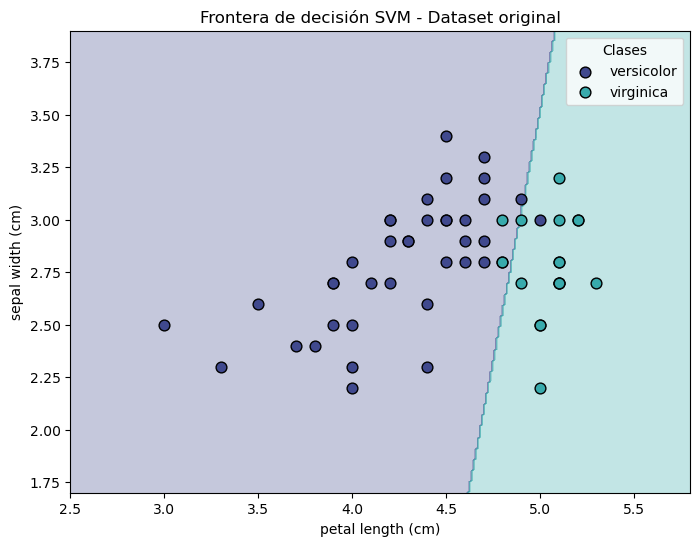

/home/jair/anaconda3/envs/CIP/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


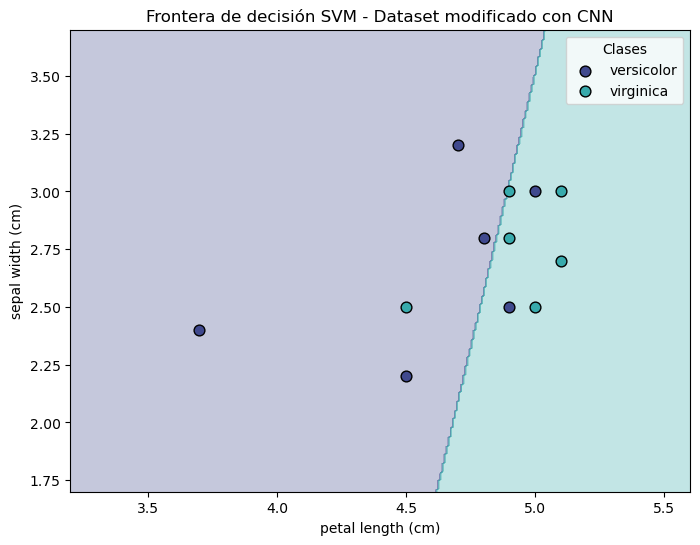

In [12]:
titulo1 = 'Frontera de decisión SVM - Dataset original'
titulo2 = 'Frontera de decisión SVM - Dataset modificado con CNN'

visualiza_svm(svm_model_df, Xdf_train, ydf_train, titulo1)
visualiza_svm(svm_model_cnn, Xcnn_train, ycnn_train, titulo2)

### Balance de los dos conjuntos

In [18]:
print("Cardinalidad Iris Dataset modificado")
print(f"{df['target'].value_counts()}")
mayor = df['target'].value_counts().max()
menor = df['target'].value_counts().min()
print(f'IR: {np.round(mayor/menor, 2)}')

print('')

print("Cardinalidad Iris Dataset modificado")
print(f"{df_cnn['target'].value_counts()}")
mayor = df_cnn['target'].value_counts().max()
menor = df_cnn['target'].value_counts().min()
print(f'IR: {np.round(mayor/menor, 2)}')

Cardinalidad Iris Dataset modificado
target
versicolor    50
virginica     20
Name: count, dtype: int64
IR: 2.5

Cardinalidad Iris Dataset modificado
target
versicolor    8
virginica     8
Name: count, dtype: int64
IR: 1.0
